In [1]:
# Based partly on http://mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# from rfpimp import *  - not easy to install on cluster

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

- This notebook takes as input two files for train and test data

### Define functions to fit + evaluate model

In [2]:
# Functions to use for prediction evaluation

def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))



In [144]:
# Train the model, measure accuracy, and error metrics

def make_model(X, y, X_valid, y_valid, n_estimators,
              max_features, min_samples_leaf, random_state):

    #global rf
    
    rf = RandomForestRegressor(n_estimators=n_estimators,
                           n_jobs=-1,
                           oob_score=True,
                           max_features=max_features, 
                           min_samples_leaf=min_samples_leaf,
                           random_state = random_state)
                           #verbose = 1

    #Inputting train dataset into the model
    rf.fit(X, y)

    return rf

In [145]:
# Using the model to make a prediction & Error Analysis for Random Forest 

def run_model(rf, X_valid):
    #global n, h, oob_valid
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    #global y_pred
    y_pred = rf.predict(X_valid)
    #global mae_valid, rmsle_valid, r2_score_valid
    mae_valid = mean_absolute_error(y_valid, y_pred)
    rmsle_valid = np.sqrt( mean_squared_error(y_valid, y_pred) )
    r2_score_valid = rf.score(X_valid, y_valid)
    
    oob_valid = rf.oob_score_

    print(f"RF OOB score {rf.oob_score_:.5f} using {n:,d} tree nodes {h} median tree height")
    print(f"Validation R^2 {r2_score_valid:.5f}, RMSLE {rmsle_valid:.5f}, MAE {mae_valid:.2f}")
    
    return y_pred,rmsle_valid,mae_valid,r2_score_valid


- **Features for this model**: area, building_type, temperature, + one-hot encoded hour, day of week, month of year

In [146]:
# Setting 'parse_dates' in this case parses both dates and times
# These files are too large to commit so they're uploaded locally under `/exploring_models` but not pushed
train_data = pd.read_csv('weather1_education_train.csv', parse_dates = ['timestamp'])
val_data = pd.read_csv('weather1_education_test.csv', parse_dates = ['timestamp'])

In [147]:
X, X_valid = train_data.drop(['electricity', 'building_name', 'primary_space_usage', 'hour', 'year', 'month','weekday', 'date', 'timestamp', 'Unnamed: 0'], axis=1), val_data.drop(['electricity', 'building_name', 'primary_space_usage', 'hour', 'year', 'month','weekday', 'date', 'timestamp', 'Unnamed: 0'], axis=1)
y, y_valid = train_data['electricity'], val_data['electricity']


In [7]:
X.head()

,area,TemperatureC,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,hour_23,wkday_0,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6,PSU_PrimClass,PSU_UnivClass
0,2777.0,7.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,2777.0,5.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,2777.0,5.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,2777.0,6.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,2777.0,7.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [8]:
y.head()

0    5.0
1    5.2
2    5.2
3    5.5
4    6.0
Name: electricity, dtype: float64

In [148]:
rf = make_model(X, y, X_valid, y_valid, 
                n_estimators = 20 ,max_features = 'auto', min_samples_leaf = 5, random_state = 42)

C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [149]:
run_model(rf, X_valid)

RF OOB score 0.90271 using 1,634,266 tree nodes 65.5 median tree height
Validation R^2 0.80509, RMSLE 13.69301, MAE 7.70


(array([19.20676703, 19.20798664, 19.44892749, ..., 10.50389359,
         9.95371542, 10.01088207]),
 13.693013740414559,
 7.702272801935758,
 0.8050929625139317)

In [155]:
# Characterize feature importance
feature_importances = pd.DataFrame(rf.feature_importances_,
                            index = X.columns,
                            columns=['importance']).sort_values('importance',ascending=False)

print(feature_importances.head(10))

              importance
area            0.600075
TemperatureC    0.039801
wkday_5         0.033079
wkday_6         0.027211
month_8         0.023619
hour_10         0.023306
hour_9          0.023181
hour_13         0.022964
hour_11         0.022791
hour_12         0.022686


### Tune hyperparameters

In [102]:
def tune_maxf(X, y, X_valid, y_valid, ntrees, maxf_min, maxf_max, maxf_step = 0.1):

# Fix minleaf while tuning this
    minleaf = 1
    
    list_of_r2_valid = []
    list_of_rmsle_valid = []
    list_of_mae_valid = []
    
    list_of_maxf = np.arange(maxf_min, maxf_max, maxf_step ).tolist()

    for maxf in np.arange(maxf_min, maxf_max, maxf_step ):
       print(f"n_estimators={ntrees}, max_features={maxf}, min_samples_leaf={minleaf}")
       rf = make_model(X, y, X_valid, y_valid, n_estimators = ntrees, 
                       max_features = maxf, min_samples_leaf = minleaf, 
                       random_state = 42)
    
       y_pred,rmsle_valid,mae_valid,r2_score_valid = run_model(rf, X_valid)
        
       list_of_r2_valid.append(r2_score_valid)
       list_of_rmsle_valid.append(rmsle_valid)
       list_of_mae_valid.append(mae_valid)
    
    
    min1 = list_of_r2_valid.index(min(list_of_r2_valid))
    min2 = list_of_rmsle_valid.index(min(list_of_rmsle_valid))
    min3 = list_of_mae_valid.index(min(list_of_mae_valid ))
                                    
    tuned_maxf = list_of_maxf[min2]
    
    print(f"tuned_maxf ={tuned_maxf}")
    
    return tuned_maxf

In [104]:
tuned_maxf = tune_maxf(X, y, X_valid, y_valid, ntrees = 10, maxf_min = 0.1, maxf_max = 0.7, maxf_step = 0.1)

n_estimators=10, max_features=0.1, min_samples_leaf=1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.6s finished
C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.2s finished


RF OOB score 0.84879 using 5,477,860 tree nodes 73.5 median tree height
Validation R^2 0.86543, RMSLE 11.37766, MAE 6.51
n_estimators=10, max_features=0.2, min_samples_leaf=1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.1s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.9s finished
C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


RF OOB score 0.88395 using 5,448,388 tree nodes 72.0 median tree height
Validation R^2 0.85286, RMSLE 11.89717, MAE 6.84
n_estimators=10, max_features=0.30000000000000004, min_samples_leaf=1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    5.3s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.0s finished
C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


RF OOB score 0.89367 using 5,377,416 tree nodes 71.5 median tree height
Validation R^2 0.84549, RMSLE 12.19165, MAE 7.03
n_estimators=10, max_features=0.4, min_samples_leaf=1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    5.6s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.3s finished
C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


RF OOB score 0.89777 using 5,288,530 tree nodes 74.0 median tree height
Validation R^2 0.84007, RMSLE 12.40381, MAE 7.19
n_estimators=10, max_features=0.5, min_samples_leaf=1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    7.0s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.4s finished
C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


RF OOB score 0.89800 using 5,204,932 tree nodes 72.0 median tree height
Validation R^2 0.83951, RMSLE 12.42520, MAE 7.24
n_estimators=10, max_features=0.6, min_samples_leaf=1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    7.3s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.9s finished
C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


RF OOB score 0.89706 using 5,139,642 tree nodes 74.0 median tree height
Validation R^2 0.83785, RMSLE 12.48937, MAE 7.28
tuned_maxf =0.1


In [106]:

def tune_minleaf(X, y, X_valid, y_valid, ntrees, maxf, minleaf_min, minleaf_max, minleaf_step = 1):

    list_of_r2_valid = []
    list_of_rmsle_valid = []
    list_of_mae_valid = []
    
    list_of_minleaf = list(range(minleaf_min, minleaf_max, minleaf_step ))

    for minleaf in range(minleaf_min, minleaf_max, minleaf_step ):
       print(f"n_estimators={ntrees}, max_features={maxf}, min_samples_leaf={minleaf}")
       rf = make_model(X, y, X_valid, y_valid, n_estimators = ntrees, max_features = maxf, min_samples_leaf = minleaf, 
                  random_state = 42)
    
       y_pred,rmsle_valid,mae_valid,r2_score_valid = run_model(rf, X_valid)
        
       list_of_r2_valid.append(r2_score_valid)
       list_of_rmsle_valid.append(rmsle_valid)
       list_of_mae_valid.append(mae_valid)
    
    
    min1 = list_of_r2_valid.index(min(list_of_r2_valid))
    min2 = list_of_rmsle_valid.index(min(list_of_rmsle_valid))
    min3 = list_of_mae_valid.index(min(list_of_mae_valid ))
                                    
    tuned_minleaf = list_of_minleaf[min2]
    
    print(f"tuned_minleaf ={tuned_minleaf}")
    
    return tuned_minleaf

In [108]:
tuned_minleaf = tune_minleaf(X, y, X_valid, y_valid, ntrees = 10, maxf = 0.1, minleaf_min = 1, minleaf_max = 7, minleaf_step = 1)

n_estimators=10, max_features=0.1, min_samples_leaf=1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.0s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.6s finished
C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.2s finished


RF OOB score 0.84879 using 5,477,860 tree nodes 73.5 median tree height
Validation R^2 0.86543, RMSLE 11.37766, MAE 6.51
n_estimators=10, max_features=0.1, min_samples_leaf=2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s finished
C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


RF OOB score 0.86451 using 2,162,942 tree nodes 70.5 median tree height
Validation R^2 0.88139, RMSLE 10.68180, MAE 6.12
n_estimators=10, max_features=0.1, min_samples_leaf=3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s finished
C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


RF OOB score 0.86277 using 1,343,186 tree nodes 67.5 median tree height
Validation R^2 0.87603, RMSLE 10.92071, MAE 6.13
n_estimators=10, max_features=0.1, min_samples_leaf=4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.7s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s finished
C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


RF OOB score 0.86146 using 940,786 tree nodes 66.0 median tree height
Validation R^2 0.86702, RMSLE 11.31040, MAE 6.27
n_estimators=10, max_features=0.1, min_samples_leaf=5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished
C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


RF OOB score 0.85063 using 722,212 tree nodes 65.0 median tree height
Validation R^2 0.86913, RMSLE 11.22040, MAE 6.26
n_estimators=10, max_features=0.1, min_samples_leaf=6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished
C:\Users\dmmma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


RF OOB score 0.84440 using 575,896 tree nodes 66.0 median tree height
Validation R^2 0.85666, RMSLE 11.74265, MAE 6.39
tuned_minleaf =2


### Fit model with selected hyperparameters


In [132]:

def fit_tuned_rf(X, y, X_valid, y_valid, ntrees, random_state = 42):
    
    rf = make_model(X, y, X_valid, y_valid, n_estimators = ntrees, 
                   max_features = tuned_maxf, min_samples_leaf = tuned_minleaf, 
                   random_state = 42)
    
    y_pred,rmsle_valid,mae_valid,r2_score_valid = run_model(rf, X_valid)

    total_len = y_pred.shape[0]
    num_buildings = len(val_data['building_name'].unique())

    #print(total_len)
    #print(num_buildings)

    y_pred_rf = y_pred.reshape((num_buildings, total_len//num_buildings))
    
    return y_pred_rf

In [133]:
y_pred_rf = fit_tuned_rf(X, y, X_valid, y_valid, ntrees = 100)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


RF OOB score 0.90505 using 21,918,360 tree nodes 69.0 median tree height
Validation R^2 0.89137, RMSLE 10.22244, MAE 5.88


In [134]:
y_pred_rf.shape

(19, 8757)

### Plot

In [135]:
num_buildings = len(val_data['building_name'].unique())

y_true = y_valid.to_numpy().reshape((num_buildings, y_valid.shape[0]//num_buildings))

y_true.shape


(19, 8757)

In [138]:
def plot_measured_predicted_1year(y_true, y_pred_rf, building_number):
    
    ''' Function to plot 'past' observed data and 'future' predicted and observed data
    Inputs: 
        y_true - observed hourly energy use
        y_pred_rf - prediction from random forest model
        building_number - pick which of num_buildings to plot
    '''
 
    plt.figure(figsize=(20, 6))

    hours_year = np.arange(0,8757,1)
    hours_3months = np.arange(0,2160,1) 
    hours_next9months = np.arange(2161, 8757, 1) 

    # For whole year
    plt.plot(hours_3months, y_true[building_number][:2160], c = 'navy', label = "3 months known data", linewidth = 0.5);
    plt.title('3 months of known data and 9 months of predictions',  fontsize = 'xx-large')

    plt.xlabel('hour of year', fontsize = 'xx-large')
    plt.ylabel('Electricity consumption in kWh', fontsize = 'xx-large')
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)


    plt.plot(hours_next9months, y_pred_rf[building_number][2161:8757], c = 'seagreen', label = "Predicted - RF", linewidth = 0.5); 

    plt.plot(hours_next9months, y_true[building_number][2161:8757], c = 'dodgerblue', label = "Actual", linewidth = 0.5);

    plt.legend( loc = "upper left", fontsize = 'x-large');

    plt.show()
    
    return

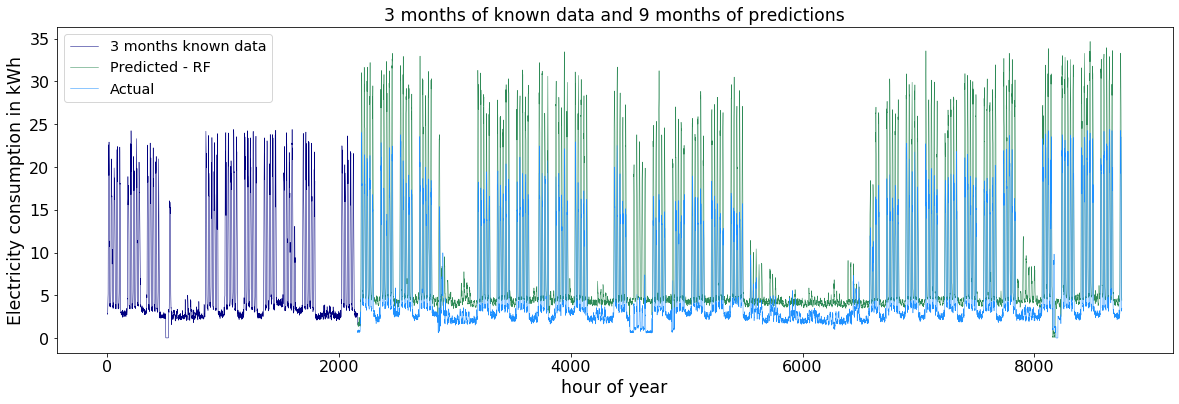

In [156]:
# Plot for some randomly selected buildings
plot_measured_predicted_1year(y_true, y_pred_rf, 1)

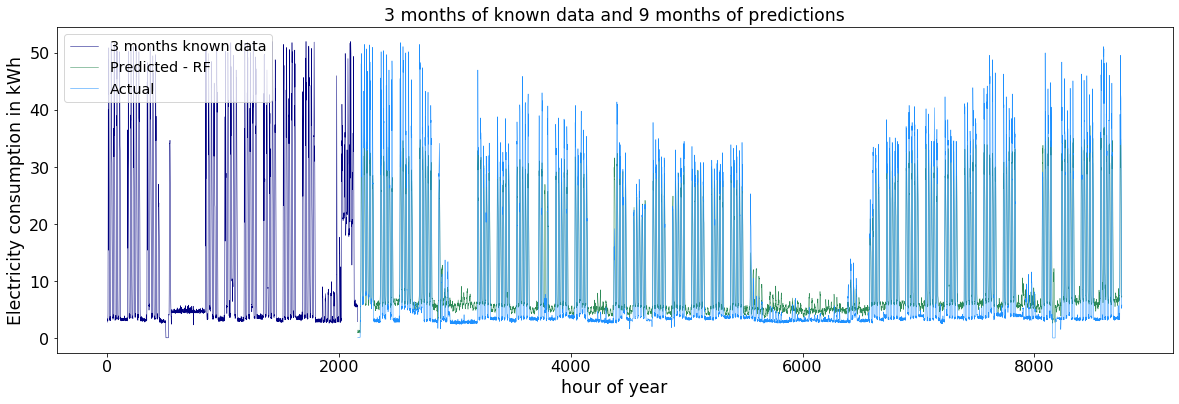

In [143]:
plot_measured_predicted_1year(y_true, y_pred_rf, 4)

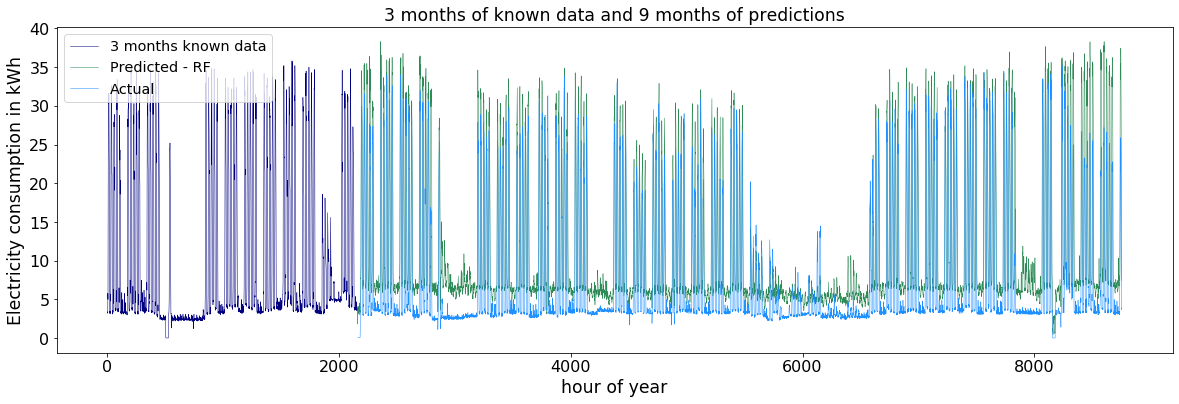

In [142]:
plot_measured_predicted_1year(y_true, y_pred_rf, 18)